# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    conv_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    output_layer = separable_conv2d_batchnorm(conv_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([small_ip_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    conv_layer   = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer = separable_conv2d_batchnorm(conv_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    bn_inputs = layers.BatchNormalization()(inputs)
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encode1 = encoder_block(bn_inputs,  64, strides=1)
    encode2 = encoder_block(encode1,   128, strides=1)
    encode3 = encoder_block(encode2,   256, strides=1)
    encode4 = encoder_block(encode3,   512, strides=1)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    middle = conv2d_batchnorm(encode4, 1024, kernel_size=1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decode4 = decoder_block(middle,  encode4, 512)
    decode3 = decoder_block(decode4, encode3, 256)
    decode2 = decoder_block(decode3, encode2, 128)
    x       = decoder_block(decode2, encode1,  64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
! ls ../data/train/images | wc -l

4131


In [9]:
! ls ../data/train/masks | wc -l

4131


In [10]:
training_samples_count = 4131

In [11]:
! ls ../data/validation/images | wc -l

1184


In [12]:
! ls ../data/validation/images | wc -l

1184


In [13]:
validation_samples_count = 1184

In [14]:
from math import ceil

learning_rate = 1e-3
batch_size = 4
num_epochs = 64
steps_per_epoch = ceil(training_samples_count / batch_size)  # 200
validation_steps = ceil(validation_samples_count / batch_size)  # 50
workers = 16

In [15]:
from tensorflow.contrib.keras.python.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(patience=2, verbose=1)
checkpoint_path = '../data/weights/weights.{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

Epoch 1/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.1150

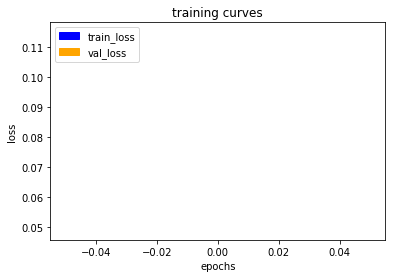

Epoch 00000: val_loss improved from inf to 0.04898, saving model to ../data/weights/weights.00-0.0490.hdf5
1033/1033 [==============================] - 897s - loss: 0.1149 - val_loss: 0.0490
Epoch 2/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0278

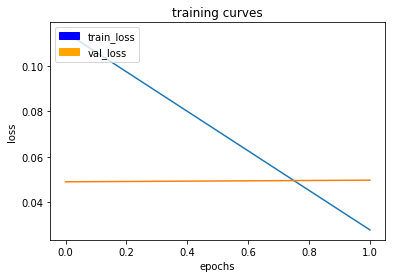

Epoch 00001: val_loss did not improve
1033/1033 [==============================] - 892s - loss: 0.0278 - val_loss: 0.0497
Epoch 3/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0239

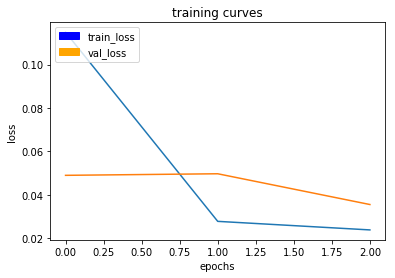

Epoch 00002: val_loss improved from 0.04898 to 0.03554, saving model to ../data/weights/weights.02-0.0355.hdf5
1033/1033 [==============================] - 892s - loss: 0.0238 - val_loss: 0.0355
Epoch 4/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0213

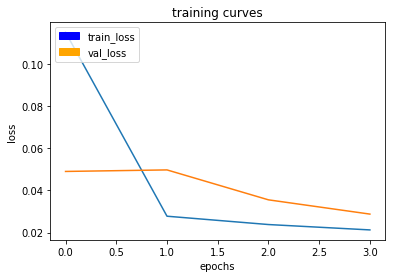

Epoch 00003: val_loss improved from 0.03554 to 0.02878, saving model to ../data/weights/weights.03-0.0288.hdf5
1033/1033 [==============================] - 892s - loss: 0.0213 - val_loss: 0.0288
Epoch 5/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0200

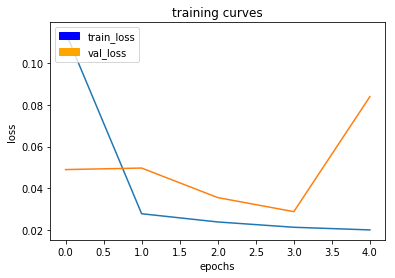

Epoch 00004: val_loss did not improve
1033/1033 [==============================] - 893s - loss: 0.0200 - val_loss: 0.0840
Epoch 6/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0187

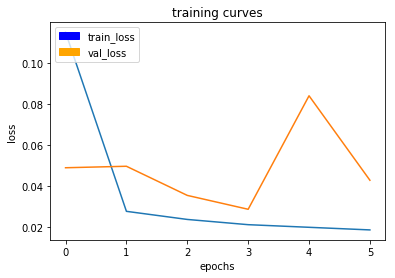

Epoch 00005: val_loss did not improve
1033/1033 [==============================] - 893s - loss: 0.0187 - val_loss: 0.0429
Epoch 7/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0173

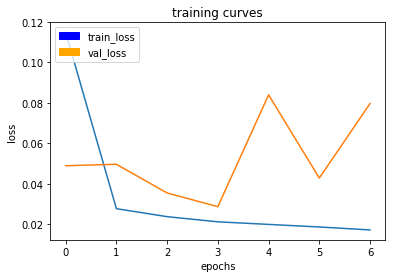


Epoch 00006: reducing learning rate to 0.00010000000474974513.
Epoch 00006: val_loss did not improve
1033/1033 [==============================] - 892s - loss: 0.0173 - val_loss: 0.0797
Epoch 8/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0145

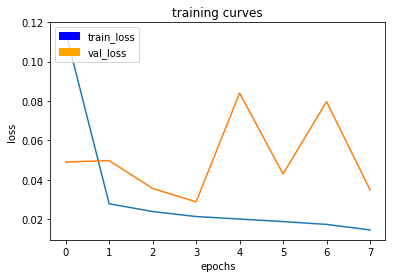

Epoch 00007: val_loss did not improve
1033/1033 [==============================] - 894s - loss: 0.0145 - val_loss: 0.0348
Epoch 9/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0127

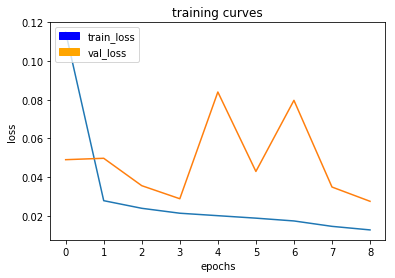

Epoch 00008: val_loss improved from 0.02878 to 0.02746, saving model to ../data/weights/weights.08-0.0275.hdf5
1033/1033 [==============================] - 894s - loss: 0.0127 - val_loss: 0.0275
Epoch 10/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0125

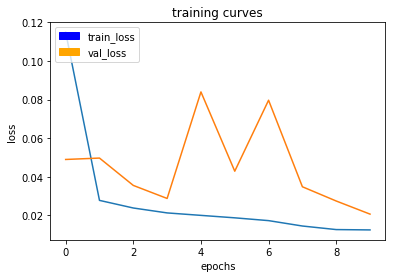

Epoch 00009: val_loss improved from 0.02746 to 0.02067, saving model to ../data/weights/weights.09-0.0207.hdf5
1033/1033 [==============================] - 893s - loss: 0.0125 - val_loss: 0.0207
Epoch 11/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0117

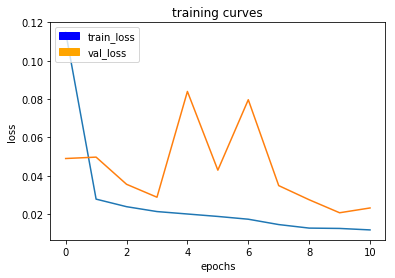

Epoch 00010: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0117 - val_loss: 0.0232
Epoch 12/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0118

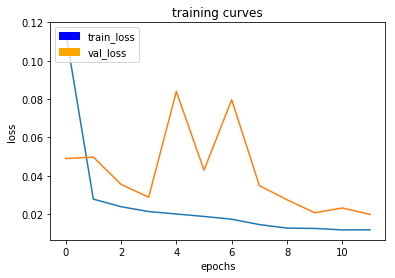

Epoch 00011: val_loss improved from 0.02067 to 0.01978, saving model to ../data/weights/weights.11-0.0198.hdf5
1033/1033 [==============================] - 894s - loss: 0.0118 - val_loss: 0.0198
Epoch 13/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0110

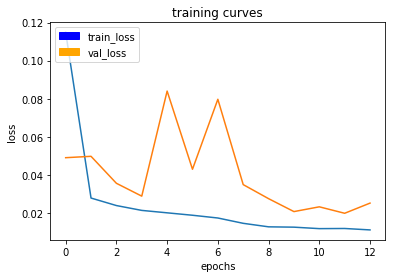

Epoch 00012: val_loss did not improve
1033/1033 [==============================] - 894s - loss: 0.0110 - val_loss: 0.0251
Epoch 14/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0107

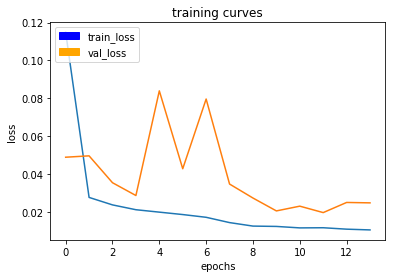

Epoch 00013: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0106 - val_loss: 0.0249
Epoch 15/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0107

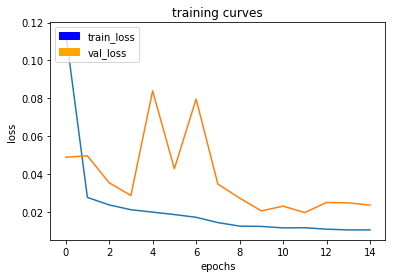


Epoch 00014: reducing learning rate to 1.0000000474974514e-05.
Epoch 00014: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0107 - val_loss: 0.0237
Epoch 16/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0099

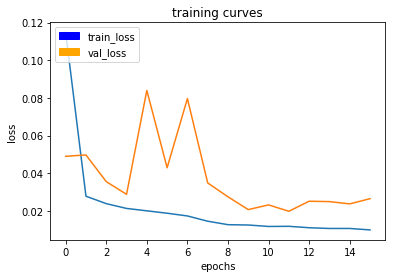

Epoch 00015: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0099 - val_loss: 0.0265
Epoch 17/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

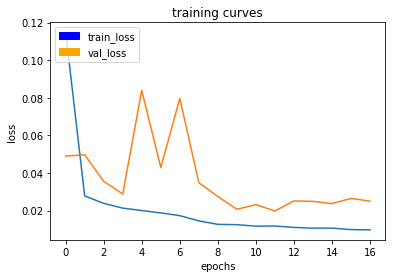


Epoch 00016: reducing learning rate to 1.0000000656873453e-06.
Epoch 00016: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0097 - val_loss: 0.0250
Epoch 18/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

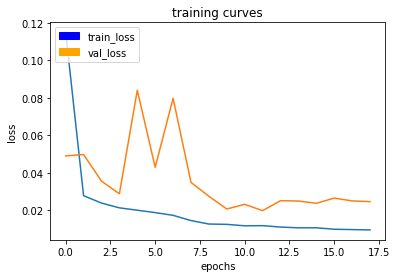

Epoch 00017: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0095 - val_loss: 0.0246
Epoch 19/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

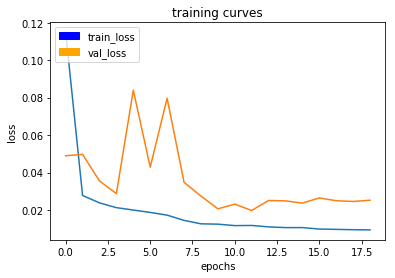


Epoch 00018: reducing learning rate to 1.0000001111620805e-07.
Epoch 00018: val_loss did not improve
1033/1033 [==============================] - 894s - loss: 0.0094 - val_loss: 0.0253
Epoch 20/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

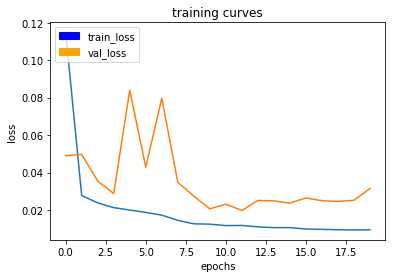

Epoch 00019: val_loss did not improve
1033/1033 [==============================] - 894s - loss: 0.0095 - val_loss: 0.0315
Epoch 21/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0098

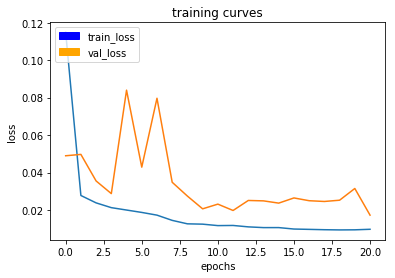

Epoch 00020: val_loss improved from 0.01978 to 0.01730, saving model to ../data/weights/weights.20-0.0173.hdf5
1033/1033 [==============================] - 895s - loss: 0.0098 - val_loss: 0.0173
Epoch 22/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

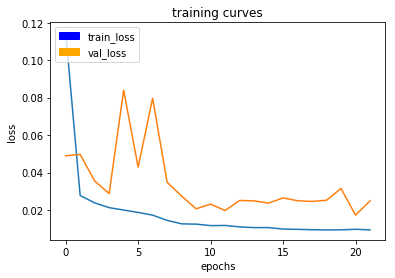

Epoch 00021: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0094 - val_loss: 0.0249
Epoch 23/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

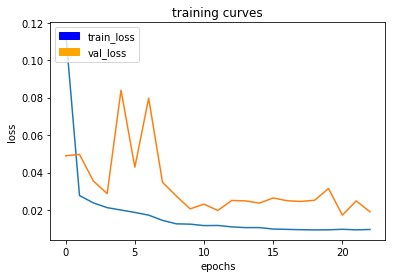

Epoch 00022: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0096 - val_loss: 0.0191
Epoch 24/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

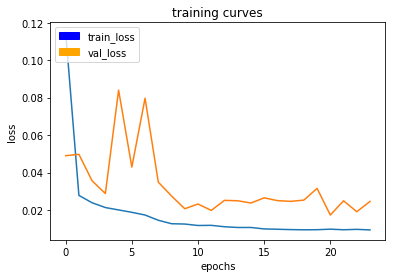


Epoch 00023: reducing learning rate to 1.000000082740371e-08.
Epoch 00023: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0094 - val_loss: 0.0246
Epoch 25/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

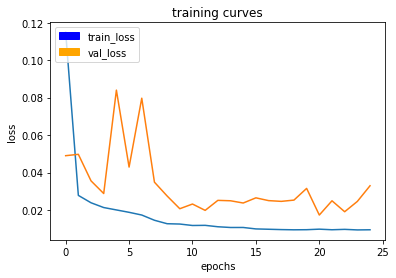

Epoch 00024: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0094 - val_loss: 0.0329
Epoch 26/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

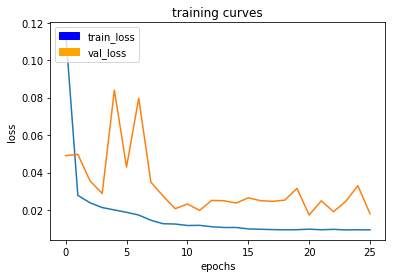


Epoch 00025: reducing learning rate to 1.000000082740371e-09.
Epoch 00025: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0094 - val_loss: 0.0180
Epoch 27/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

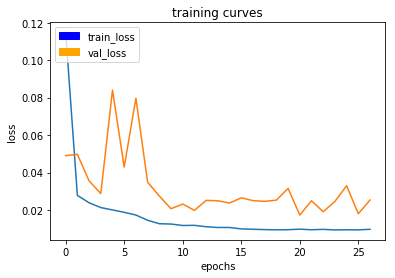

Epoch 00026: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0097 - val_loss: 0.0253
Epoch 28/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

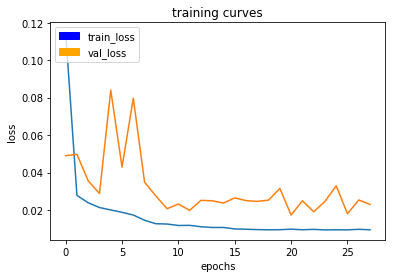


Epoch 00027: reducing learning rate to 1.000000082740371e-10.
Epoch 00027: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0094 - val_loss: 0.0229
Epoch 29/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

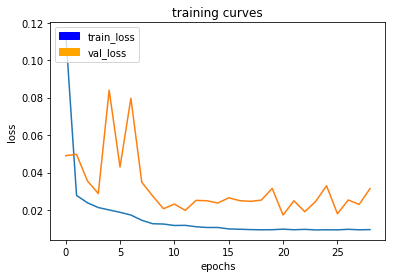

Epoch 00028: val_loss did not improve
1033/1033 [==============================] - 896s - loss: 0.0095 - val_loss: 0.0314
Epoch 30/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

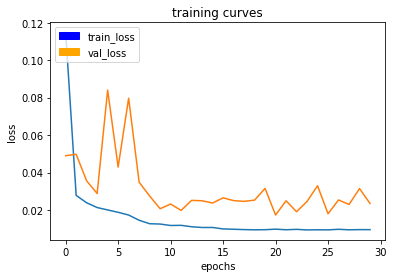


Epoch 00029: reducing learning rate to 1.000000082740371e-11.
Epoch 00029: val_loss did not improve
1033/1033 [==============================] - 896s - loss: 0.0095 - val_loss: 0.0235
Epoch 31/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0096

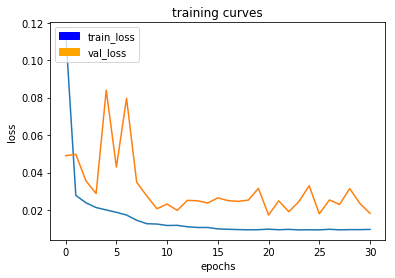

Epoch 00030: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0096 - val_loss: 0.0182
Epoch 32/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0093

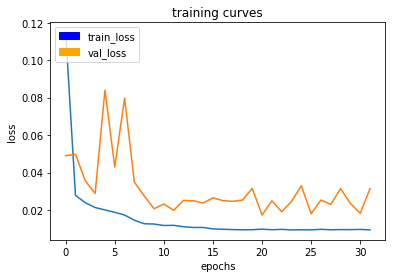


Epoch 00031: reducing learning rate to 1.000000082740371e-12.
Epoch 00031: val_loss did not improve
1033/1033 [==============================] - 895s - loss: 0.0093 - val_loss: 0.0315
Epoch 33/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

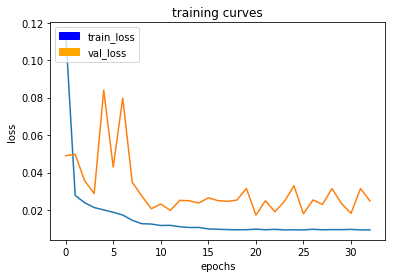

Epoch 00032: val_loss did not improve
1033/1033 [==============================] - 896s - loss: 0.0094 - val_loss: 0.0248
Epoch 34/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

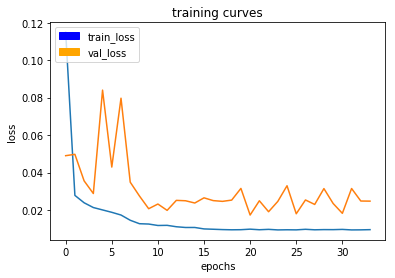


Epoch 00033: reducing learning rate to 1.0000001044244145e-13.
Epoch 00033: val_loss did not improve
1033/1033 [==============================] - 898s - loss: 0.0095 - val_loss: 0.0247
Epoch 35/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

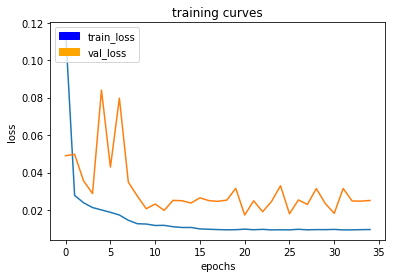

Epoch 00034: val_loss did not improve
1033/1033 [==============================] - 898s - loss: 0.0095 - val_loss: 0.0251
Epoch 36/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

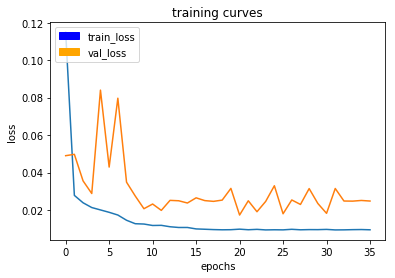


Epoch 00035: reducing learning rate to 1.0000001179769417e-14.
Epoch 00035: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0094 - val_loss: 0.0248
Epoch 37/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

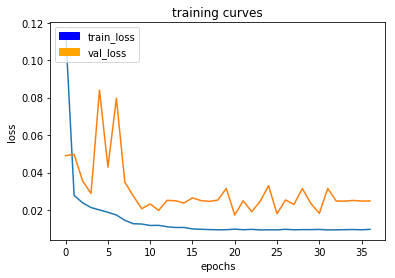

Epoch 00036: val_loss did not improve
1033/1033 [==============================] - 898s - loss: 0.0097 - val_loss: 0.0248
Epoch 38/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

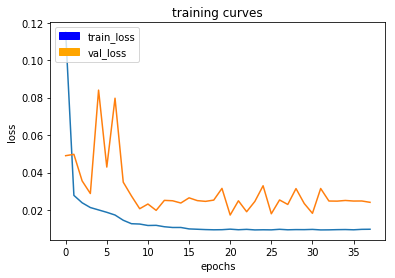


Epoch 00037: reducing learning rate to 1.0000001518582595e-15.
Epoch 00037: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0097 - val_loss: 0.0241
Epoch 39/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

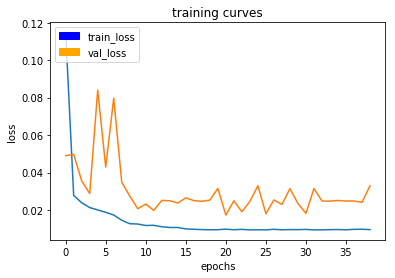

Epoch 00038: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0095 - val_loss: 0.0330
Epoch 40/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

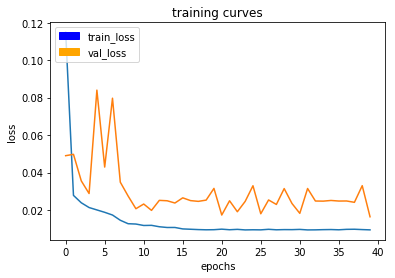

Epoch 00039: val_loss improved from 0.01730 to 0.01636, saving model to ../data/weights/weights.39-0.0164.hdf5
1033/1033 [==============================] - 900s - loss: 0.0094 - val_loss: 0.0164
Epoch 41/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

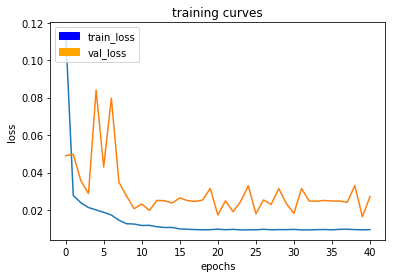

Epoch 00040: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0095 - val_loss: 0.0272
Epoch 42/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

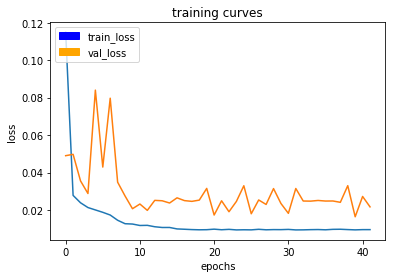

Epoch 00041: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0095 - val_loss: 0.0217
Epoch 43/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

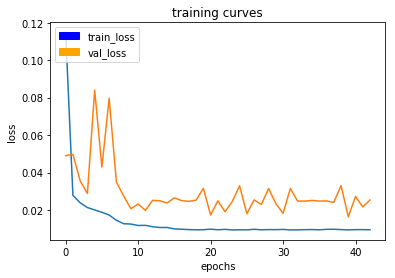


Epoch 00042: reducing learning rate to 1.0000001095066122e-16.
Epoch 00042: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0094 - val_loss: 0.0253
Epoch 44/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

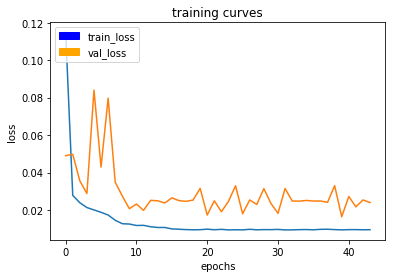

Epoch 00043: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0095 - val_loss: 0.0240
Epoch 45/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

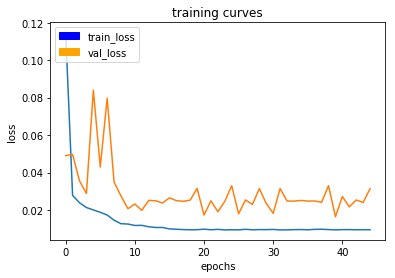


Epoch 00044: reducing learning rate to 1.0000000830368326e-17.
Epoch 00044: val_loss did not improve
1033/1033 [==============================] - 901s - loss: 0.0094 - val_loss: 0.0314
Epoch 46/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

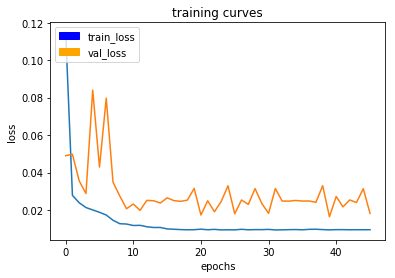

Epoch 00045: val_loss did not improve
1033/1033 [==============================] - 899s - loss: 0.0095 - val_loss: 0.0182
Epoch 47/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

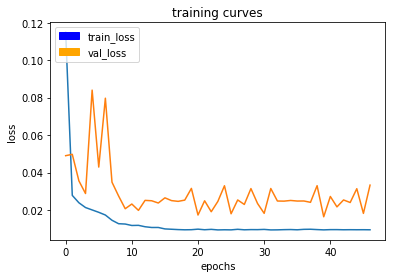


Epoch 00046: reducing learning rate to 1.0000000664932204e-18.
Epoch 00046: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0094 - val_loss: 0.0333
Epoch 48/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

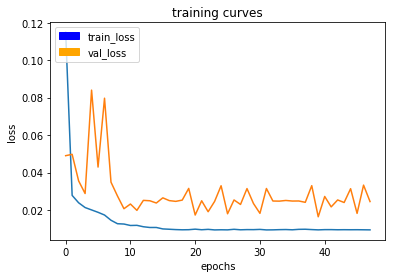

Epoch 00047: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0094 - val_loss: 0.0245
Epoch 49/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

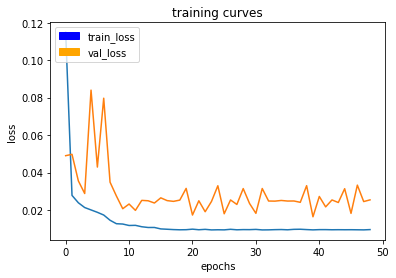


Epoch 00048: reducing learning rate to 1.000000045813705e-19.
Epoch 00048: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0254
Epoch 50/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

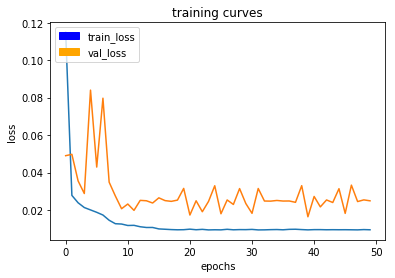

Epoch 00049: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0094 - val_loss: 0.0249
Epoch 51/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

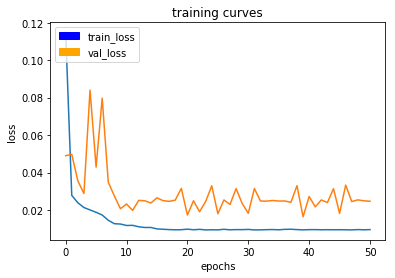


Epoch 00050: reducing learning rate to 1.000000032889008e-20.
Epoch 00050: val_loss did not improve
1033/1033 [==============================] - 901s - loss: 0.0095 - val_loss: 0.0247
Epoch 52/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0094

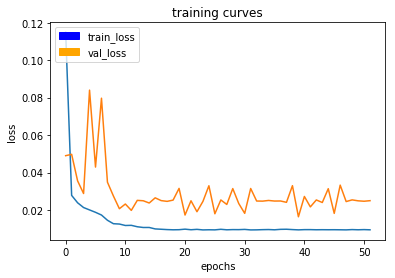

Epoch 00051: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0094 - val_loss: 0.0250
Epoch 53/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

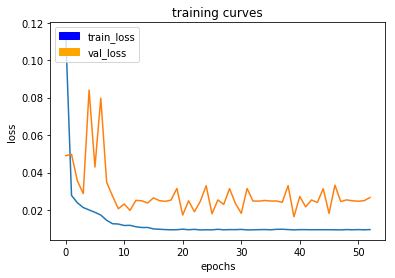


Epoch 00052: reducing learning rate to 1.0000000490448793e-21.
Epoch 00052: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0267
Epoch 54/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

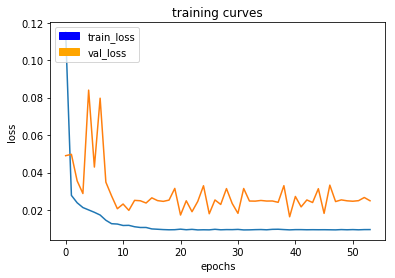

Epoch 00053: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0249
Epoch 55/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

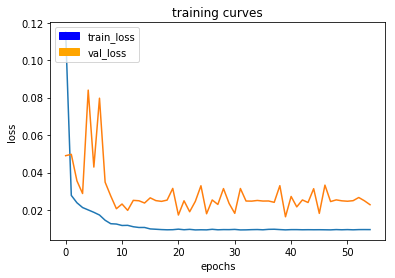


Epoch 00054: reducing learning rate to 1.0000000692397185e-22.
Epoch 00054: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0228
Epoch 56/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0096

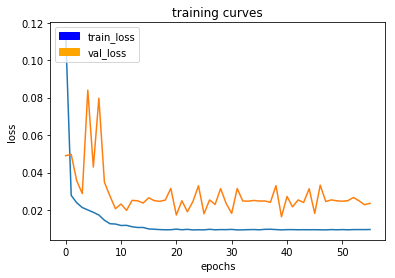

Epoch 00055: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0096 - val_loss: 0.0236
Epoch 57/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0096

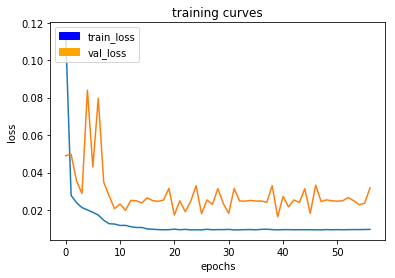


Epoch 00056: reducing learning rate to 1.0000000944832675e-23.
Epoch 00056: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0096 - val_loss: 0.0318
Epoch 58/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

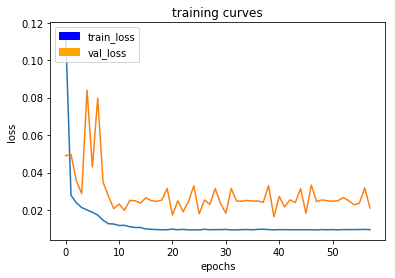

Epoch 00057: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0210
Epoch 59/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

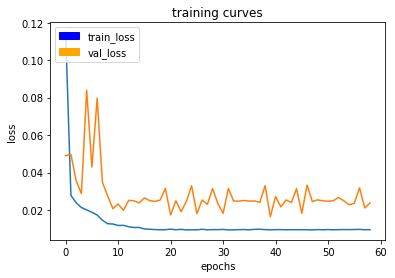


Epoch 00058: reducing learning rate to 1.0000000787060494e-24.
Epoch 00058: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0095 - val_loss: 0.0237
Epoch 60/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0093

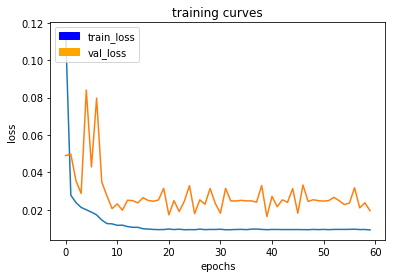

Epoch 00059: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0093 - val_loss: 0.0195
Epoch 61/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0095

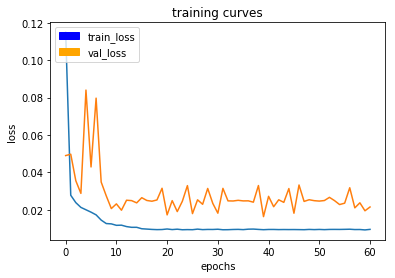


Epoch 00060: reducing learning rate to 1.0000001181490946e-25.
Epoch 00060: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0096 - val_loss: 0.0215
Epoch 62/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0093

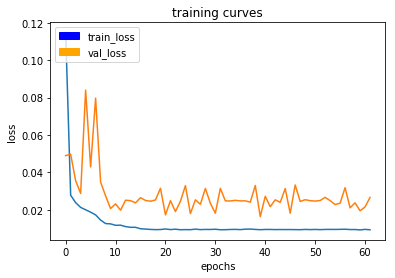

Epoch 00061: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0093 - val_loss: 0.0266
Epoch 63/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0093

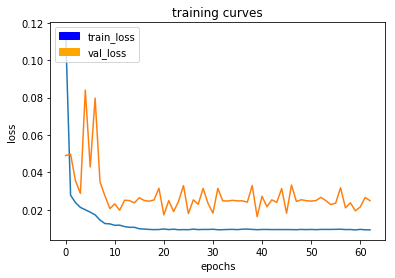


Epoch 00062: reducing learning rate to 1.0000001428009978e-26.
Epoch 00062: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0093 - val_loss: 0.0249
Epoch 64/64
1032/1033 [============================>.] - ETA: 0s - loss: 0.0097

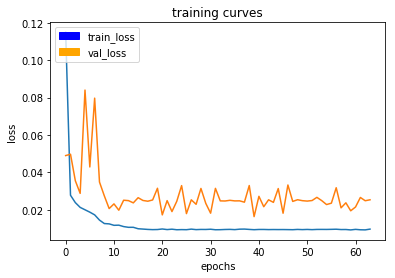

Epoch 00063: val_loss did not improve
1033/1033 [==============================] - 900s - loss: 0.0097 - val_loss: 0.0254


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb, reduce_lr, checkpoint]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [17]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [18]:
! cp ../data/weights/weights.39-0.0164.hdf5 ../data/weights/model_weights

In [19]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [20]:
! rm -rf ../data/runs/*

In [21]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

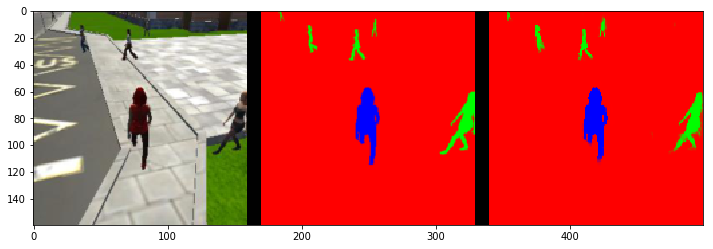

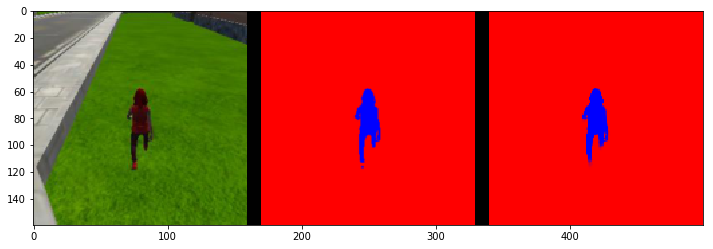

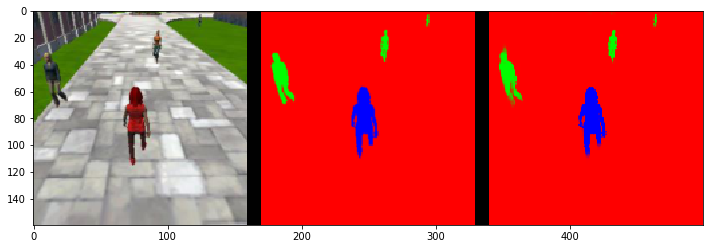

In [22]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

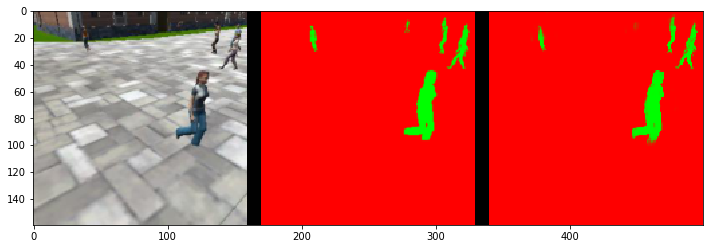

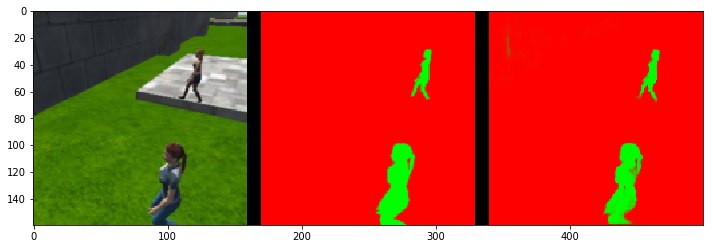

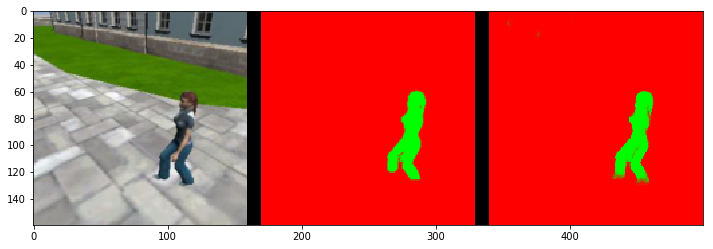

In [23]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

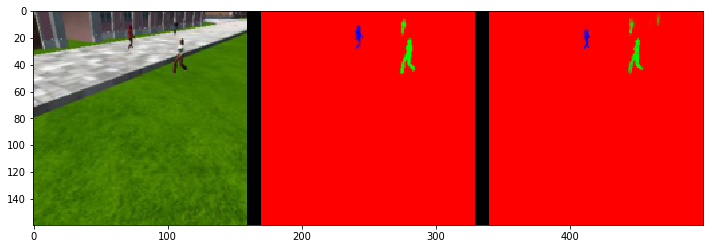

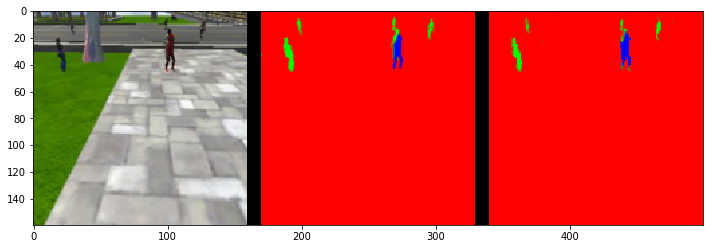

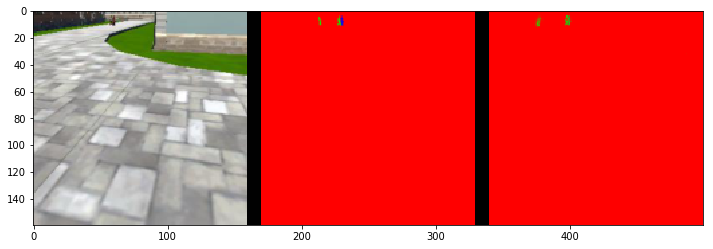

In [24]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [25]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9966731117946923
average intersection over union for other people is 0.4342667798707303
average intersection over union for the hero is 0.9274943738352345
number true positives: 539, number false positives: 0, number false negatives: 0


In [26]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9897567536036541
average intersection over union for other people is 0.7944758375808646
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 40, number false negatives: 0


In [27]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9972807608902766
average intersection over union for other people is 0.5227080158468785
average intersection over union for the hero is 0.35137131017785966
number true positives: 167, number false positives: 1, number false negatives: 134


In [28]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.8013620885357549


In [29]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.639432842007


In [30]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.512417237749
